[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mahmouddraz/xai/blob/main/notebooks/shap/shap_solution.ipynb)

In [ ]:
! pip install shap

# SHAP for Tabular data - Strole data

## Load datasets

In [ ]:
X_train = pickle.load(open('/content/drive/MyDrive/XAI workshop/datasets/X_train_stroke.pickle', 'rb'))
X_test = pickle.load(open('/content/drive/MyDrive/XAI workshop/datasets/X_test_stroke.pickle', 'rb'))
y_train = pickle.load(open('/content/drive/MyDrive/XAI workshop/datasets/y_train_stroke.pickle', 'rb'))
y_test= pickle.load(open('/content/drive/MyDrive/XAI workshop/datasets/y_test_stroke.pickle', 'rb'))

## Load model-- RandomForestClassfier model

In [ ]:
f = open("/content/drive/MyDrive/XAI workshop/Models/clf_pipe_line.pickle", "rb")
pipeline = pickle.load(f)

In [ ]:
pipeline

## Model evalution

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
y_pred = pipeline.predict(X_test)

In [ ]:
# evaluate model
print('Accuracy Score:')
print(str(round(accuracy_score(y_test, y_pred), 2) * 100) + "%")

## Create explainer with SHAP for the RF model

In [ ]:
explainer = shap.TreeExplainer(pipeline['model'])

### Get hte feature names and X_train_encoded

In [ ]:
categorical_features = ["gender", "ever_married", "work_type", "Residence_type", "smoking_status"]
numeric_features = ["id", "age", "hypertension", "avg_glucose_level", "bmi", "heart_disease"]

cat_features = pipeline['preprocessor'].transformers_[1][1]['onehot'].get_feature_names_out(categorical_features)
num_features = pipeline['preprocessor'].transformers_[0][1]['scaler'].get_feature_names_out(numeric_features)

feature_names= cat_features.tolist() + num_features.tolist()
feature_names_shuffled = np.random.shuffle(feature_names)

In [ ]:
X_train_encoded = pipeline['preprocessor'].transform(X_test)

## Calculate the shap_values for the features 

In [ ]:
shap_values = explainer.shap_values(X_train_encoded)

## Visualize the explaintions

### Summary plot

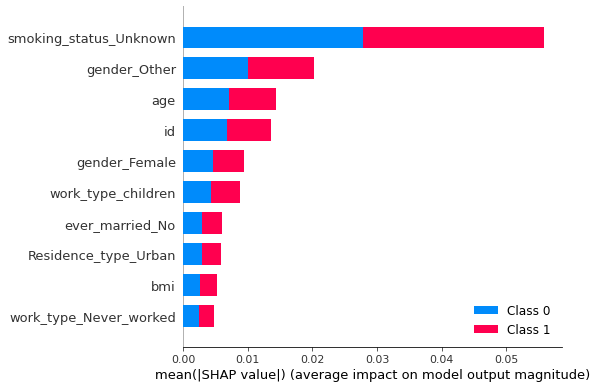

In [ ]:
shap.summary_plot(shap_values=shap_values, feature_names=feature_names, max_display=10)

### Force Plot

In [ ]:
shap.initjs()
shap.force_plot(base_value=explainer.expected_value[0], shap_values=shap_values[0][:1], feature_names=feature_names)

### Decision plot

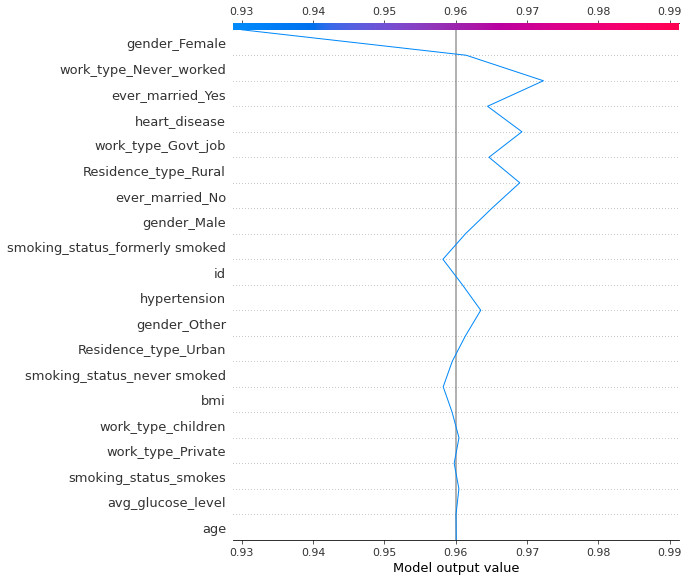

In [ ]:
shap.initjs()
shap.decision_plot(base_value=explainer.expected_value[0], shap_values=shap_values[0][:1], feature_names=feature_names)

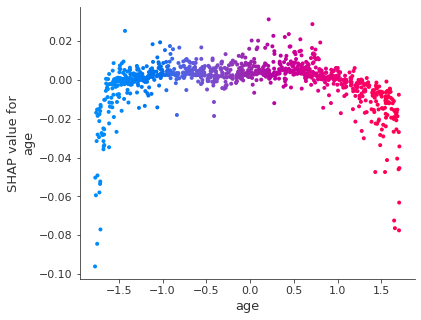

In [ ]:
shap.dependence_plot(ind=0, shap_values=shap_values[0], interaction_index='age', features=X_train_encoded, feature_names=feature_names)

# Cats vs Dogs 

In [ ]:
import tensorflow as tf 
import tensorflow_datasets as tfds
import shap 
import pickle
from sklearn.metrics import accuracy_score
import pickle 
import numpy as np
from matplotlib import pyplot as plt

## Load model

In [ ]:
model_cnn = tf.keras.models.load_model("/content/drive/MyDrive/XAI workshop/Models/dnn_model.h5")
model_cnn.summary()

## Load data

In [ ]:
def normalize(image, label):

  # cast to float
  image = tf.cast(image, tf.float32)
  # normalize the pixel values
  image = image / 255
  # resize to 300 x 300
  image = tf.image.resize(image, (300,300))

  return image, label


def get_data():

     setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

     train_data, info = tfds.load('cats_vs_dogs', split='train[:80%]', as_supervised=True, with_info=True)
     validation_data = tfds.load('cats_vs_dogs', split='train[80%:90%]', as_supervised=True)
     test_data = tfds.load('cats_vs_dogs', split='train[-10%:]', as_supervised=True)

     train_data = train_data.map(normalize)
     validation_data = validation_data.map(normalize)
     test_data = test_data.map(normalize)

     train_batches = train_data.batch(batch_size=32, drop_remainder=True)
     test_batches = test_data.batch(batch_size=32, drop_remainder=True)
     validation_batches = validation_data.batch(batch_size=32, drop_remainder=True)

     return train_data, test_data, validation_data, train_batches, test_batches, validation_batches, info

In [ ]:
train_data, test_data, validation_data, train_batches, test_batches, validation_batches, info = get_data()

In [ ]:
tfds.show_examples(train_data, info)

## Test the model

In [ ]:
# evaluate the model
test_loss, test_accuracy = model_cnn.evaluate(test_batches)
print('Test loss: {}'.format(test_loss))
print('Test accuracy: {}'.format(test_accuracy))

In [ ]:
test_dataset_1 = test_data.batch(batch_size=1)

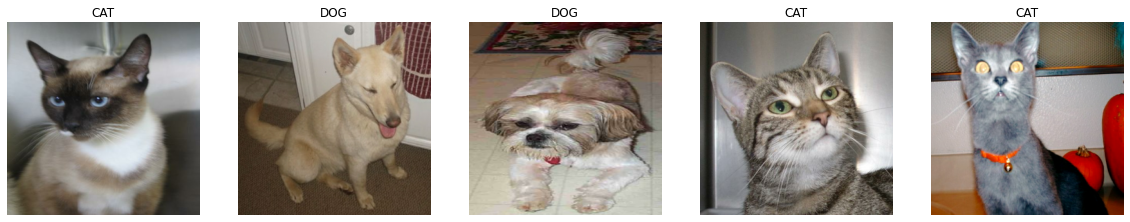

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(20, 25))
class_names = ["CAT", 'DOG']
i = 0
for image, label in test_dataset_1.take(5):
    res = model_cnn.predict(image)
    pred_lable = int(res >= 0.5)  
    axs[i].axis('off')
    axs[i].set_title(class_names[pred_lable])
    axs[i].imshow(image[0])
    i +=1 
plt.show()

## Make explainer

In [ ]:
def get_shap_data(data, SAMPLE_SIZE): 
  test_data_np = tfds.as_numpy(data.take(SAMPLE_SIZE))
  image_list = []
  for image in test_data_np: 
    image_list.append(image[0])

  return np.array(image_list)

In [ ]:
background = get_shap_data(train_data, 5000)


In [ ]:
shap_sample = get_shap_data(test_data, 3)

In [ ]:
shap_sample.shape

(10, 300, 300, 3)

In [ ]:
# deep_explainer = shap.DeepExplainer(model=model_cnn, data=background)
deep_explainer = shap.GradientExplainer(model=model_cnn, data=background)

In [ ]:
shap_values = deep_explainer.shap_values(shap_sample)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [ ]:
shap_values[0].shape

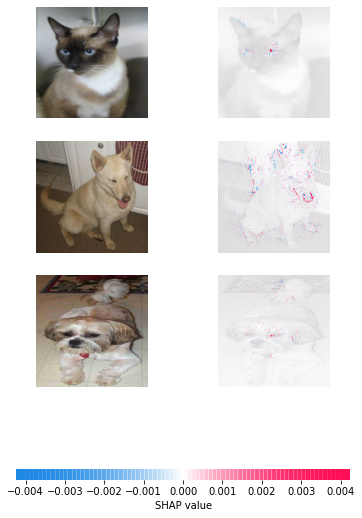

In [ ]:
shap.image_plot(shap_values[0], shap_sample[:10])